In [1]:
            import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist = fetch_openml('mnist_784', cache=False)

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [5]:
X /= 255.0

X = X.reshape(-1, 1, 28, 28)
X.shape

(70000, 1, 28, 28)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((56000, 1, 28, 28), (14000, 1, 28, 28), (56000,), (14000,))

In [28]:
class Model(nn.Module): 
    
    def __init__(self, dropout=0.5, con_l1=32, con_l2=64, fc1=64): 

        super().__init__()

        self.conv1 = nn.Conv2d(1, con_l1, kernel_size=3)
        self.conv2 = nn.Conv2d(con_l1, con_l2, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)

        flatten_dim=con_l2*5*5 # number channels * width * height

        self.fc1 = nn.Linear(flatten_dim, fc1) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(fc1, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self,x): 
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [9]:
!pip install skorch

In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

# Define the loss function
loss_function = nn.CrossEntropyLoss()

#Early Stopping
from skorch.callbacks import EarlyStopping

my_early = EarlyStopping(
    monitor='valid_loss',
    patience=10,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True)

#Model initialization
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    module=Model,
    module__con_l1=32,
    module__con_l2=64,
    module__fc1=64,
    max_epochs=50,
    #lr=0.002,
    device=device,
    optimizer = optim.Adam,
    optimizer__lr=0.001,
    optimizer__weight_decay=1e-5, #L2 norm
    criterion=nn.CrossEntropyLoss,
    callbacks = [my_early],
)


Training device: cpu


In [31]:
from sklearn.model_selection import GridSearchCV

#CNN
params = {
    'module__con_l1': [16, 32],
    'module__con_l2': [32, 48],
    'max_epochs': [50],
    'optimizer__lr':[0.01, 0.001],
    'optimizer__weight_decay':[1e-4,1e-5] #L2 norm,
}


gs = GridSearchCV(net, params, refit=True, cv=3, scoring="neg_mean_squared_error",verbose=3)

gs.fit(X_train, y_train)

print(gs.best_score_, gs.best_params_)
net=gs.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_epochs=50, module__con_l1=16, module__con_l2=32, optimizer__lr=0.01, optimizer__weight_decay=0.0001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8640       0.9124        1.5502  14.0735
      2        1.6276       0.9408        1.5200  13.4936
      3        1.5983       0.9332        1.5279  14.9106
      4        1.6006       0.9549        1.5065  15.1074
      5        1.5994       0.9553        1.5060  14.8707
      6        1.5970       0.9492        1.5117  14.4044
      7        1.5881       0.9546        1.5063  15.4842
      8        1.5869       0.9535        1.5075  23.2107
      9        1.5907       0.9538        1.5072  25.1777
     10        1.5827       0.9582        1.5027  24.2389
     11        1.5961       0.9569        1.5039  24.1894
     12        1.5918       0.9527        1.5085  21.3199
     13        1.5919       0.9519        1.5089  22.6855
     14        1.5978       0.9427        1.5181  21.7902
     15        1.5860       0.9582        1.5030  19.2627
     16       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8883       0.8140        1.6459  13.9141
      2        1.6852       0.9207        1.5402  14.1879
      3        1.6441       0.9164        1.5442  14.8197
      4        1.6352       0.9273        1.5337  14.4497
      5        1.6374       0.9223        1.5386  14.6063
      6        1.6307       0.9263        1.5347  14.3686
      7        1.6336       0.9325        1.5289  15.1343
      8        1.6465       0.9302        1.5308  18.3922
      9        1.6376       0.9316        1.5296  20.6529
     10        1.6415       0.9235        1.5375  22.3223
     11        1.6262       0.9138        1.5473  23.4577
     12        1.6351       0.9332        1.5279  24.1289
     13        1.6262       0.9251        1.5358  25.0064
     14        1.6297       0.9387        1.5226  26.7138
     15        1.6418       0.9089        1.5524  28.4574
     16       

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.3min remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8037       0.9006        1.5601  13.7768
      2        1.6405       0.9213        1.5396  13.1674
      3        1.6189       0.9313        1.5290  14.0951
      4        1.6191       0.9377        1.5237  15.6283
      5        1.6067       0.9383        1.5231  14.5914
      6        1.6144       0.9419        1.5188  14.6653
      7        1.6122       0.9288        1.5320  16.6972
      8        1.6227       0.9436        1.5173  19.4557
      9        1.6219       0.9271        1.5342  23.0435
     10        1.6387       0.9289        1.5323  25.4357
     11        1.6366       0.9274        1.5339  28.0750
     12        1.6252       0.9048        1.5561  30.1635
     13        1.6467       0.9219        1.5393  30.5818
     14        1.6377       0.9200        1.5411  29.9267
     15        1.6468       0.9267        1.5343  29.4588
     16       

     19        1.5119       0.9775        1.4844  21.1104
     20        1.5109       0.9782        1.4836  22.6281
     21        1.5106       0.9774        1.4844  23.3762
     22        1.5095       0.9782        1.4833  23.3999
     23        1.5097       0.9794        1.4821  25.1471
     24        1.5072       0.9790        1.4824  25.4748
     25        1.5070       0.9784        1.4826  25.0027
     26        1.5059       0.9814        1.4801  24.9566
     27        1.5075       0.9794        1.4817  25.1187
     28        1.5062       0.9802        1.4811  15.8424
     29        1.5070       0.9790        1.4826  14.6258
     30        1.5043       0.9813        1.4802  14.4740
     31        1.5052       0.9813        1.4804  15.6376
     32        1.5038       0.9819        1.4797  16.7776
     33        1.5039       0.9810        1.4804  16.3870
     34        1.5030       0.9823        1.4796  15.5810
     35        1.5020       0.9819        1.4793  15.8154
     36       

     23        1.5087       0.9732        1.4879  13.8912
     24        1.5059       0.9768        1.4845  13.7305
     25        1.5070       0.9778        1.4840  14.0746
     26        1.5067       0.9760        1.4848  13.7736
     27        1.5053       0.9766        1.4844  13.8027
     28        1.5060       0.9774        1.4845  15.5424
     29        1.5043       0.9795        1.4824  16.4242
     30        1.5035       0.9778        1.4833  16.8523
     31        1.5028       0.9788        1.4824  17.2670
     32        1.5016       0.9787        1.4824  18.2410
     33        1.5011       0.9770        1.4840  20.4664
     34        1.5013       0.9790        1.4824  21.7889
     35        1.5012       0.9817        1.4801  23.9629
     36        1.5017       0.9795        1.4812  22.6300
     37        1.5006       0.9790        1.4819  22.8105
     38        1.5015       0.9813        1.4804  24.0882
     39        1.5003       0.9814        1.4807  24.4401
     40       

     23        1.5056       0.9768        1.4841  14.7141
     24        1.5067       0.9779        1.4833  14.1925
     25        1.5038       0.9763        1.4851  14.6439
     26        1.5038       0.9783        1.4832  14.5203
     27        1.5026       0.9774        1.4834  14.2962
     28        1.5032       0.9786        1.4828  14.2870
     29        1.5023       0.9792        1.4818  14.5296
     30        1.5009       0.9803        1.4812  14.5546
     31        1.5014       0.9780        1.4830  14.6189
     32        1.5005       0.9795        1.4813  14.3470
     33        1.5004       0.9804        1.4811  13.4680
     34        1.5004       0.9802        1.4809  13.2710
     35        1.4984       0.9786        1.4825  13.5607
     36        1.4996       0.9810        1.4807  13.2746
     37        1.4963       0.9810        1.4805  13.4013
     38        1.4985       0.9807        1.4803  13.3620
     39        1.4983       0.9802        1.4805  13.3276
     40       

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.7730       0.9266        1.5342  15.4466
      2        1.6152       0.9423        1.5186  16.3240
      3        1.6031       0.9420        1.5190  19.0521
      4        1.5937       0.9443        1.5167  20.0950
      5        1.5954       0.9500        1.5111  18.0417
      6        1.6146       0.9350        1.5258  18.0849
      7        1.6140       0.9380        1.5232  18.7560
      8        1.6089       0.9143        1.5471  20.3404
      9        1.6397       0.9176        1.5432  25.6490
     10        1.6214       0.9340        1.5271  35.5708
     11        1.6329       0.9371        1.5240  43.9134
     12        1.6364       0.9089        1.5525  30.0805
     13        1.6412       0.9209        1.5402  29.7626
     14        1.6414       0.9176        1.5436  31.1308
Stopping since valid_loss has not improved in the last 10 epochs.
[CV]  

     12        1.5191       0.9732        1.4881  18.0790
     13        1.5159       0.9754        1.4860  18.0102
     14        1.5138       0.9768        1.4848  17.7096
     15        1.5120       0.9774        1.4837  16.9009
     16        1.5113       0.9780        1.4836  16.4324
     17        1.5099       0.9788        1.4826  16.9845
     18        1.5085       0.9803        1.4817  16.7625
     19        1.5074       0.9808        1.4808  16.3566
     20        1.5059       0.9794        1.4817  16.6869
     21        1.5061       0.9811        1.4807  16.7226
     22        1.5052       0.9811        1.4800  16.2326
     23        1.5045       0.9826        1.4793  15.5242
     24        1.5036       0.9822        1.4793  16.2641
     25        1.5013       0.9829        1.4789  16.6792
     26        1.5016       0.9829        1.4785  16.9155
     27        1.5001       0.9834        1.4782  16.8332
     28        1.4988       0.9829        1.4784  16.7554
     29       

     12        1.5185       0.9709        1.4914  21.1234
     13        1.5164       0.9707        1.4908  22.4522
     14        1.5163       0.9685        1.4924  23.3792
     15        1.5118       0.9704        1.4903  25.2769
     16        1.5155       0.9711        1.4902  18.3390
     17        1.5146       0.9725        1.4884  17.1681
     18        1.5100       0.9728        1.4889  18.8347
     19        1.5105       0.9738        1.4871  21.4987
     20        1.5078       0.9733        1.4879  23.1800
     21        1.5098       0.9750        1.4868  24.0429
     22        1.5083       0.9763        1.4859  26.4519
     23        1.5078       0.9756        1.4857  27.6121
     24        1.5046       0.9760        1.4857  30.1711
     25        1.5040       0.9771        1.4845  32.0336
     26        1.5054       0.9766        1.4844  32.0628
     27        1.5035       0.9756        1.4854  33.1109
     28        1.5022       0.9775        1.4839  35.3228
     29       

     13        1.5174       0.9689        1.4920  19.0601
     14        1.5120       0.9729        1.4881  18.7159
     15        1.5107       0.9733        1.4878  18.4698
     16        1.5098       0.9729        1.4882  17.9420
     17        1.5096       0.9758        1.4863  17.5672
     18        1.5076       0.9750        1.4861  18.7037
     19        1.5074       0.9754        1.4853  20.2113
     20        1.5079       0.9770        1.4846  21.2623
     21        1.5064       0.9767        1.4845  20.1127
     22        1.5049       0.9787        1.4831  26.4973
     23        1.5032       0.9780        1.4837  19.3574
     24        1.5024       0.9788        1.4818  19.3011
     25        1.5014       0.9807        1.4813  20.3791
     26        1.5022       0.9802        1.4814  20.5347
     27        1.4998       0.9800        1.4809  19.6532
     28        1.5001       0.9792        1.4820  20.6377
     29        1.4999       0.9800        1.4810  20.0420
     30       

     16        1.6470       0.9296        1.5317  40.1093
     17        1.6472       0.9336        1.5275  41.4178
     18        1.6456       0.9367        1.5244  39.0523
     19        1.6390       0.9344        1.5268  38.4651
     20        1.6356       0.9330        1.5281  37.7673
     21        1.6374       0.9249        1.5361  40.3916
     22        1.6409       0.9357        1.5253  36.1382
     23        1.6390       0.9346        1.5265  34.5196
Stopping since valid_loss has not improved in the last 10 epochs.
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.01, optimizer__weight_decay=0.0001, score=-1.085, total=13.9min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.01, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8526       0.9091        1.5525  19.3842
      2        1.6514       0.9301        1.531

      7        1.6892       0.9083        1.5528  26.5897
      8        1.6844       0.9016        1.5595  44.6899
      9        1.6754       0.9184        1.5425  47.9177
     10        1.6791       0.9278        1.5332  51.8737
     11        1.6753       0.9132        1.5480  53.4303
     12        1.7027       0.9150        1.5461  55.2122
     13        1.7436       0.9032        1.5578  57.5543
Stopping since valid_loss has not improved in the last 10 epochs.
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.01, optimizer__weight_decay=1e-05, score=-1.216, total= 9.1min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8641       0.8408        1.6213  18.8269
      2        1.6205       0.9427        1.5217  18.7362
      3        1.5704       0.9490        1.513

     46        1.4989       0.9818        1.4795  23.4914
     47        1.4969       0.9835        1.4776  28.6016
     48        1.4966       0.9846        1.4768  30.0988
     49        1.4969       0.9831        1.4783  32.3919
     50        1.4962       0.9819        1.4795  35.6416
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=0.0001, score=-0.285, total=23.4min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8979       0.8752        1.6000  21.1783
      2        1.6212       0.9352        1.5300  21.1524
      3        1.5763       0.9425        1.5202  20.7055
      4        1.5609       0.9486        1.5122  20.6249
      5        1.5488       0.9537        1.5073  20.4309
      6        1.5441       0.9573        1.5048  21.

     49        1.4988       0.9831        1.4779  31.5434
     50        1.4986       0.9833        1.4781  24.9969
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=1e-05, score=-0.302, total=24.0min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=1e-05 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8881       0.8215        1.6413  21.1853
      2        1.6688       0.8517        1.6085  21.3746
      3        1.6246       0.9413        1.5213  21.0467
      4        1.5630       0.9530        1.5092  21.8766
      5        1.5462       0.9555        1.5055  22.5182
      6        1.5391       0.9609        1.5006  23.2447
      7        1.5339       0.9650        1.4962  22.9941
      8        1.5294       0.9642        1.4963  23.0231
      9        1.5275       0.9646        1.4957  25.22

[CV]  max_epochs=50, module__con_l1=32, module__con_l2=32, optimizer__lr=0.001, optimizer__weight_decay=1e-05, score=-0.354, total=23.4min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.01, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.9428       0.7869        1.6724  24.1981
      2        1.6929       0.9289        1.5321  24.7464
      3        1.6401       0.9415        1.5196  24.7657
      4        1.6217       0.9475        1.5131  25.1031
      5        1.6205       0.9427        1.5185  25.0937
      6        1.6332       0.9388        1.5222  24.5608
      7        1.6272       0.9337        1.5269  26.5236
      8        1.6238       0.9379        1.5233  35.9206
      9        1.6227       0.9455        1.5155  46.0366
     10        1.6192       0.9397        1.5213  41.7999
     11        1.6515       0.9341        1.5268  35.26

      7        1.6669       0.9326        1.5282  31.2208
      8        1.6616       0.9373        1.5237  61.4906
      9        1.6657       0.9152        1.5461  70.4760
     10        1.6838       0.8986        1.5626  72.4748
     11        1.7199       0.9305        1.5308  77.8462
     12        1.7216       0.9147        1.5463  78.2004
     13        1.7294       0.9271        1.5338  78.0301
Stopping since valid_loss has not improved in the last 10 epochs.
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.01, optimizer__weight_decay=1e-05, score=-1.609, total=11.9min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8423       0.9250        1.5437  22.7987
      2        1.5937       0.9456        1.5175  23.1931
      3        1.5612       0.9551        1.507

     45        1.4948       0.9837        1.4772  51.5218
     46        1.4930       0.9846        1.4769  52.0882
     47        1.4927       0.9835        1.4777  55.9495
     48        1.4945       0.9838        1.4776  54.0721
     49        1.4914       0.9857        1.4761  55.4325
     50        1.4921       0.9835        1.4778  61.9869
[CV]  max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.001, optimizer__weight_decay=0.0001, score=-0.273, total=37.4min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.001, optimizer__weight_decay=0.0001 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8459       0.8452        1.6190  23.9769
      2        1.6468       0.9368        1.5273  23.7019
      3        1.5655       0.9563        1.5063  24.3199
      4        1.5463       0.9581        1.5036  23.6589
      5        1.5339       0.9597        1.5014  25.

[CV]  max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.001, optimizer__weight_decay=1e-05, score=-0.270, total=24.1min
[CV] max_epochs=50, module__con_l1=32, module__con_l2=48, optimizer__lr=0.001, optimizer__weight_decay=1e-05 
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8432       0.9068        1.5616  23.6780
      2        1.6109       0.9368        1.5264  22.9599
      3        1.5729       0.9452        1.5172  24.5494
      4        1.5545       0.9553        1.5065  24.1092
      5        1.5440       0.9586        1.5029  25.1272
      6        1.5359       0.9622        1.4995  25.7181
      7        1.5313       0.9656        1.4963  25.7663
      8        1.5275       0.9660        1.4957  26.6829
      9        1.5238       0.9673        1.4941  26.3139
     10        1.5239       0.9693        1.4926  27.0344
     11        1.5209       0.9672        1.4938  26.82

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 739.5min finished


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8358       0.8406        1.6220  35.2367
      2        1.5932       0.9486        1.5136  35.6806
      3        1.5561       0.9566        1.5054  35.5962
      4        1.5431       0.9637        1.4982  36.0390
      5        1.5326       0.9654        1.4963  36.1990
      6        1.5306       0.9666        1.4941  36.7570
      7        1.5227       0.9686        1.4928  36.4941
      8        1.5199       0.9698        1.4910  36.2889
      9        1.5199       0.9704        1.4910  37.1164
     10        1.5160       0.9737        1.4875  37.2837
     11        1.5137       0.9759        1.4859  42.4578
     12        1.5120       0.9738        1.4877  57.7175
     13        1.5103       0.9777        1.4842  79.8304
     14        1.5084       0.9756        1.4859  94.1870
     15        1.5082       0.9799        1.4818  99.7098
     16       

In [32]:
net.fit(X_train, y_train)

Re-initializing module because the following parameters were re-set: con_l1, con_l2, fc1.
Re-initializing optimizer because the following parameters were re-set: lr, weight_decay.
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.8355       0.8407        1.6231  34.4816
      2        1.5989       0.9517        1.5102  32.6092
      3        1.5507       0.9599        1.5019  33.1398
      4        1.5367       0.9623        1.4992  33.7320
      5        1.5297       0.9655        1.4955  35.0822
      6        1.5254       0.9690        1.4928  36.0559
      7        1.5196       0.9696        1.4917  35.2352
      8        1.5158       0.9728        1.4888  53.7750
      9        1.5141       0.9742        1.4872  77.6542
     10        1.5116       0.9767        1.4851  78.4968
     11        1.5096       0.9779        1.4836  84.4982
     12        1.5083       0.9783        1.4832  88.7186
     13 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Model(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
    (conv2_drop): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=1200, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=10, bias=True)
    (fc1_drop): Dropout(p=0.5, inplace=False)
  ),
)

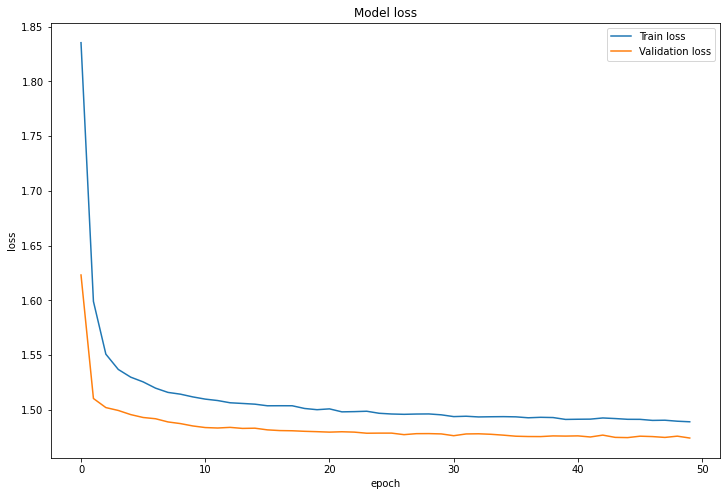

In [33]:
# get train losses from all epochs, a list of floats
history = net.history
train_loss_log=history[:, 'train_loss']
val_loss_log=history[:, 'valid_loss']

# Plot losses
plt.figure(figsize=(12,8))
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score
y_pred = net.predict(X_test)

test_acc = accuracy_score(y_test, y_pred)
print(test_acc)

0.9840714285714286


In [35]:
#Accuracy
val_acc=history[:, 'valid_acc'][-1]
val_loss=history[:, 'valid_loss'][-1]
train_loss=history[:, 'train_loss'][-1]

print("Train Loss:\t",round(train_loss,3))
print("Val Acc:\t",round(val_acc,3))
print("Test Acc:\t",round(float(test_acc),3))

Train Loss:	 1.489
Val Acc:	 0.988
Test Acc:	 0.984


In [36]:
#Access network parameters
my_best_net = net.module_

# Conv 1 layer
c1_w = my_best_net.conv1.weight.data.cpu().numpy()
c1_b = my_best_net.conv1.bias.data.cpu().numpy()

# Conv 2 layer
c2_w = my_best_net.conv2.weight.data.cpu().numpy()
c2_b = my_best_net.conv2.bias.data.cpu().numpy()

#First hidden Layer
h1_w = my_best_net.fc1.weight.data.cpu().numpy()
h1_b = my_best_net.fc1.bias.data.cpu().numpy()

#Second hidden Layer
h2_w = my_best_net.fc2.weight.data.cpu().numpy()
h2_b = my_best_net.fc2.bias.data.cpu().numpy()

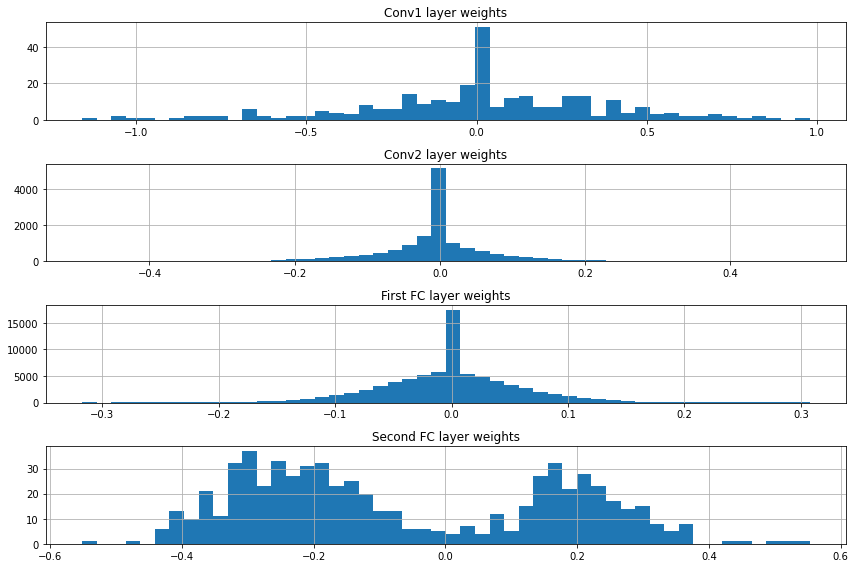

In [18]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('Conv1 layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Conv2 layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First FC layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second FC layer weights')

[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

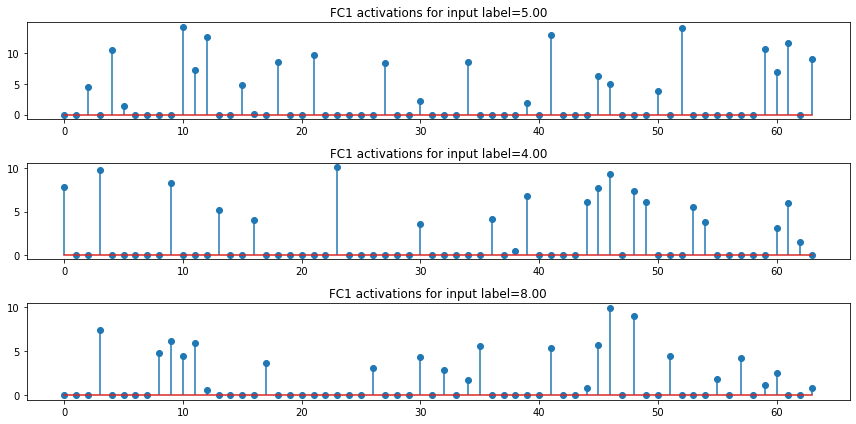

In [37]:
def get_activation(layer, input, output):
    global activation
    #activation = torch.softmax(output)
    activation = torch.relu(output)
    
### Register hook
net=my_best_net
hook_handle = net.fc1.register_forward_hook(get_activation)


### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor(X_train[0]).unsqueeze(0).to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor(X_train[1]).unsqueeze(0).to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor(X_train[2]).unsqueeze(0).to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('FC1 activations for input label=%.2f' % y_train[0])
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('FC1 activations for input label=%.2f' % y_train[1])
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('FC1 activations for input label=%.2f' % y_train[2])
plt.tight_layout()
plt.show()

In [39]:
def visualize_receptive_field(image):
    input = torch.ones_like(image, requires_grad=True)
    out = net(input)
    sig = nn.Sigmoid()
    
    prediction = torch.argmax(sig(net(image)), dim=1) #prediction of the true image
    #print(sig(out))

    grad = torch.zeros_like(out, requires_grad=True)
    grad[0][prediction] = 1
    #print(grad)

    out.backward(gradient=grad)
    gradient_of_input = input.grad[0, 0].data.cpu().numpy()
    gradient_of_input = gradient_of_input / np.amax(gradient_of_input)

    def normalize(activations):
        # transform activations so that all the values be in range [0, 1]
        activations = activations - np.min(activations[:])
        activations = activations / np.max(activations[:])
        return activations


    def visualize_activations(image, activations):
        activations = normalize(activations)

        # replicate the activations to go from 1 channel to 3
        # as we have colorful input image
        # we could use cvtColor with GRAY2BGR flag here, but it is not
        # safe - our values are floats, but cvtColor expects 8-bit or
        # 16-bit inttegers
        masked_image = (image * activations)

        return masked_image


    receptive_field_mask = visualize_activations(image.cpu().numpy(), gradient_of_input)
    plt.imshow(receptive_field_mask[0][0], cmap='Greys')
    plt.show()
    #return receptive_field_mask[0][0]

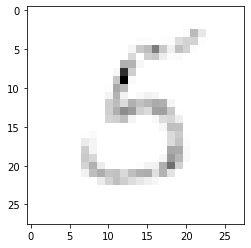

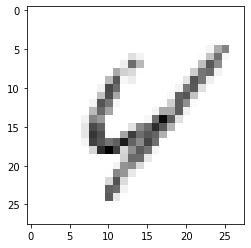

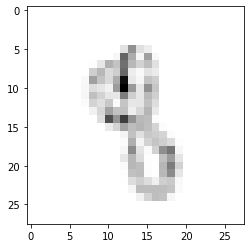

In [38]:
visualize_receptive_field(x1)
visualize_receptive_field(x2)
visualize_receptive_field(x3)

In [40]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

In [41]:
error_mask = y_pred != y_test

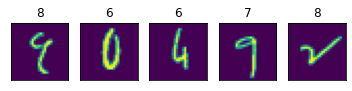

In [42]:
plot_example(X_test[error_mask], y_pred[error_mask])